# Pipeline to Train Model for MI

This notebook details the steps and pipeline to train a CNN that takes in a standard 12-lead ECG consisting of 4 channels, each of 10 seconds. It will then predict if the ECG has Myocardial Infarction

## Set up Notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_code import *
from sklearn.preprocessing import StandardScaler
import time
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

## Load dataset csv
The dataset here basically has the filenames of each recording, and the tf.Dataset object will load the recording itself during the training

In [2]:
full_df = pd.read_csv("full_dataset.csv")
full_df

,Recording,Afib,Afl,MI,SVT,DB
0,data/cpsc/A4924.mat,0,0,0,0,CP
1,data/cpsc/A2054.mat,0,0,0,0,CP
2,data/cpsc/A5391.mat,0,0,0,0,CP
3,data/cpsc/A3580.mat,0,0,0,0,CP
4,data/cpsc/A4948.mat,0,0,0,0,CP
...,...,...,...,...,...,...
85738,data/ningbo/JS32861.mat,0,0,0,0,NI
85739,data/ningbo/JS41305.mat,0,0,0,0,NI
85740,data/ningbo/JS25189.mat,0,0,0,0,NI
85741,data/ningbo/JS42616.mat,0,0,0,0,NI


In [4]:
train_val_df = full_df[full_df['DB'] != 'C2']
train_val_df

,Recording,Afib,Afl,MI,SVT,DB
0,data/cpsc/A4924.mat,0,0,0,0,CP
1,data/cpsc/A2054.mat,0,0,0,0,CP
2,data/cpsc/A5391.mat,0,0,0,0,CP
3,data/cpsc/A3580.mat,0,0,0,0,CP
4,data/cpsc/A4948.mat,0,0,0,0,CP
...,...,...,...,...,...,...
85738,data/ningbo/JS32861.mat,0,0,0,0,NI
85739,data/ningbo/JS41305.mat,0,0,0,0,NI
85740,data/ningbo/JS25189.mat,0,0,0,0,NI
85741,data/ningbo/JS42616.mat,0,0,0,0,NI


In [5]:
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

In [6]:
# Ensure that the % of MI is the same as the 20% train test split
print("% of MI in test: {}".format(val_df['MI'].sum()/train_val_df['MI'].sum()))

% of MI in test: 0.2025598219254313


## Visualize Data Augmentations

We increase the dataset with 3 augmentations:
1. Adding low freq sine wave as baseline wander
2. Adding 50Hz power line noise
3. Adding random gaussian noise

This augmentation also adds noise to the training data and thus makes the model more robust to noise

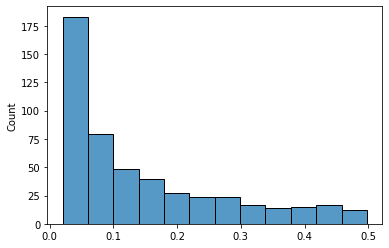

In [7]:
# Use loguniform so as to concentrate the randomness in the lower spectrum

from scipy.stats import loguniform

arr = []
for i in range(500):
    arr.append(loguniform.rvs(0.02, 0.5, size=None))
    
sns.histplot(data=arr)
plt.show()

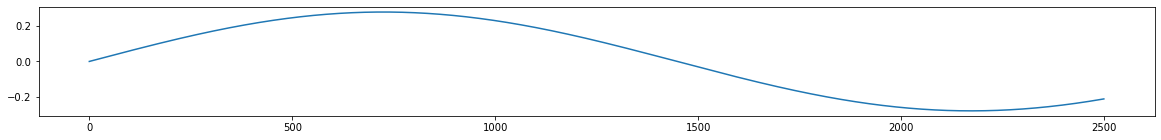

In [8]:
# Baseline Wander

def get_bw(qrs_amp):
    amp = np.random.rand() * 0.15 * qrs_amp      # Amplitude
    f = loguniform.rvs(0.02, 0.5, size=None)     # Frequency
    fs = 250                                     # Sample Rate
    t = 10

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)

y = get_bw(6)

plt.figure(figsize=(20,2))
plt.plot(list(range(len(y))), y)

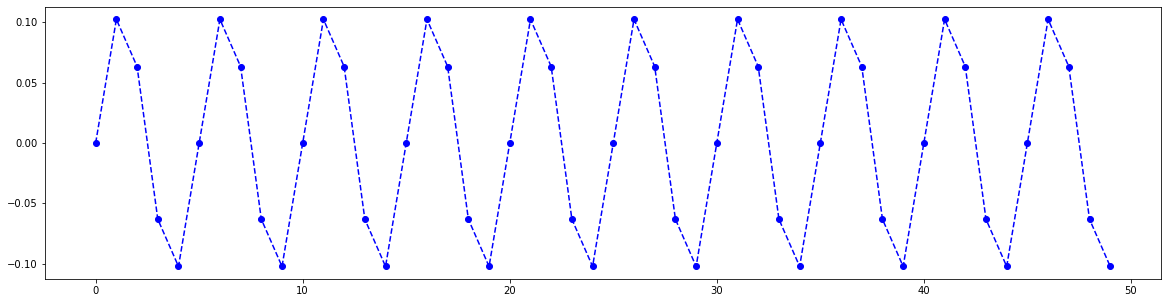

In [9]:
# Power Line

def get_pli(qrs_amp):
    amp = qrs_amp * 0.025 * np.random.rand()    # Amplitude
    f = 50     # Frequency
    fs = 250     # Sample Rate
    t = 10

    x = np.arange(fs * t)
    y = [amp*np.sin(2 * np.pi * f * (i/fs)) for i in x]
    
    return np.array(y)
    
y = get_pli(6.5)

plt.figure(figsize=(20,5))
plt.plot(list(range(len(y[:50]))), y[:50], '--bo')

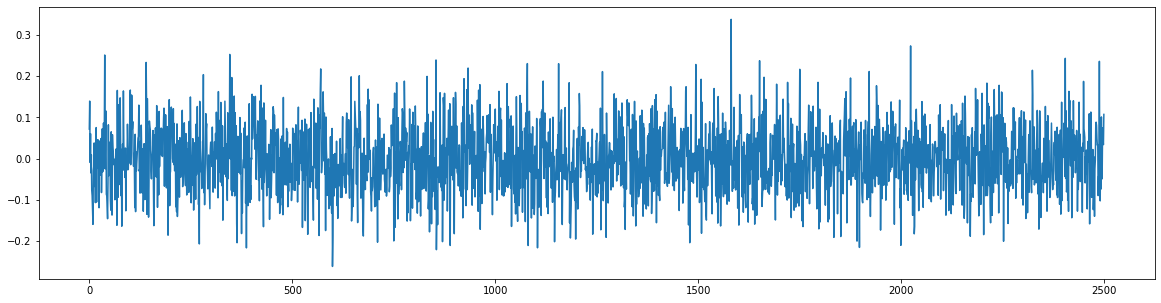

In [10]:
# Gaussian Noise

def get_gauss():
    gauss = np.random.normal(0, 0.08, (2500,))
    
    return gauss

gauss = get_gauss()

plt.figure(figsize=(20,5))
plt.plot(list(range(len(gauss))), gauss)

In [14]:
# Function to randomly augment any ECG lead with noise

def augment_leads(leads, aug_no):
    new_leads = []
    
    for lead in leads:
        qrs_amp = max(lead.max(), abs(lead.min()))
        
        if aug_no == 2:
            lead = lead + get_bw(qrs_amp)
        elif aug_no == 3:
            lead = lead + get_pli(qrs_amp)
        elif aug_no == 4:
            lead = lead + get_gauss()
        
        new_leads.append(lead)
    
    return np.array(new_leads)

## Upsample MI Positive Data

Due to class imbalance, the positive data has to be upsampled

In [20]:
mi_train = train_df[['Recording', 'MI']]
mi_train

,Recording,MI
18036,data/georgia/E02096.mat,0
83766,data/ningbo/JS22721.mat,0
25188,data/ptbxl/HR00083.mat,0
23912,data/ptbxl/HR13179.mat,1
42194,data/chapman/JS07570.mat,0
...,...,...
9066,data/georgia/E05152.mat,0
57687,data/ningbo/JS34839.mat,0
79621,data/ningbo/JS36549.mat,0
860,data/cpsc/A5399.mat,0


In [21]:
mi_train_F = mi_train[mi_train['MI'] == 0]
mi_train_F

,Recording,MI
18036,data/georgia/E02096.mat,0
83766,data/ningbo/JS22721.mat,0
25188,data/ptbxl/HR00083.mat,0
42194,data/chapman/JS07570.mat,0
43807,data/chapman/JS05904.mat,0
...,...,...
9066,data/georgia/E05152.mat,0
57687,data/ningbo/JS34839.mat,0
79621,data/ningbo/JS36549.mat,0
860,data/cpsc/A5399.mat,0


In [22]:
mi_train_T = mi_train[mi_train['MI'] == 1]
mi_train_T

,Recording,MI
23912,data/ptbxl/HR13179.mat,1
27689,data/ptbxl/HR01275.mat,1
21803,data/ptbxl/HR15721.mat,1
21149,data/ptbxl/HR05444.mat,1
33190,data/ptbxl/HR11917.mat,1
...,...,...
26220,data/ptbxl/HR05219.mat,1
38721,data/ptbxl/HR13170.mat,1
26698,data/ptbxl/HR12368.mat,1
38574,data/ptbxl/HR09617.mat,1


In [23]:
# increase positive afl examples to reduce class imbalance
for i in range(10):
    mi_train_T = pd.concat([mi_train_T, mi_train[mi_train['MI'] == 1]], ignore_index=True)
mi_train_T

,Recording,MI
0,data/ptbxl/HR13179.mat,1
1,data/ptbxl/HR01275.mat,1
2,data/ptbxl/HR15721.mat,1
3,data/ptbxl/HR05444.mat,1
4,data/ptbxl/HR11917.mat,1
...,...,...
47284,data/ptbxl/HR05219.mat,1
47285,data/ptbxl/HR13170.mat,1
47286,data/ptbxl/HR12368.mat,1
47287,data/ptbxl/HR09617.mat,1


In [26]:
mi_train = pd.concat([mi_train_T, mi_train_F], ignore_index=True)
mi_train = mi_train.sample(frac=1).reset_index(drop=True)
mi_train

,Recording,MI
0,data/georgia/E01477.mat,0
1,data/ptbxl/HR08587.mat,1
2,data/chapman/JS07851.mat,0
3,data/ptbxl/HR06450.mat,1
4,data/chapman/JS02616.mat,0
...,...,...
109338,data/ningbo/JS22822.mat,0
109339,data/ningbo/JS39695.mat,0
109340,data/ningbo/JS22442.mat,0
109341,data/ptbxl/HR12169.mat,1


In [27]:
x_train = np.array(mi_train['Recording'])
x_train

array(['data/georgia/E01477.mat', 'data/ptbxl/HR08587.mat',
       'data/chapman/JS07851.mat', ..., 'data/ningbo/JS22442.mat',
       'data/ptbxl/HR12169.mat', 'data/ptbxl/HR08693.mat'], dtype=object)

In [28]:
y_train = np.array(mi_train[['MI']])
y_train.shape

(109343, 1)

In [29]:
x_val = np.array(val_df['Recording'])
x_val

array(['data/ningbo/JS25106.mat', 'data/ptbxl/HR11970.mat',
       'data/ningbo/JS33102.mat', ..., 'data/chapman/JS08588.mat',
       'data/chapman/JS07155.mat', 'data/chapman/JS02694.mat'],
      dtype=object)

In [30]:
y_val = np.array(val_df[['MI']])
y_val.shape

(16589, 1)

## Dataset Prep

In [31]:
import tensorflow as tf
print(tf.__version__)

2.4.2


In [32]:
scaler = StandardScaler()

In [33]:
def get_ecg(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:2] # resample to 250Hz
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T
        
        # Random number from 1 to 6. 
        # 2, 3, 4 will have augmentations, 1, 5, 6, will be original
        lead = augment_leads(lead, np.random.randint(1, 7))
        
        channels = []
        channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
        channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
        channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
        channels.append(lead[1])
        channels = np.array(channels)
        
        return channels.astype(np.float32).T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (2500, 4))

    return recording, label

In [34]:
def get_val(filename, label):
    def process_mat(filename):
        recording = load_recording(filename)
        recording = recording.astype(np.float32).T
        recording = recording[0:5000:2] # resample to 250Hz
        recording = scaler.fit_transform(recording) # Normalize
        lead = recording.T
        
        channels = []
        channels.append(np.concatenate((lead[0][:625], lead[3][625:1250], lead[6][1250:1875], lead[9][1875:])))
        channels.append(np.concatenate((lead[1][:625], lead[4][625:1250], lead[7][1250:1875], lead[10][1875:])))
        channels.append(np.concatenate((lead[2][:625], lead[5][625:1250], lead[8][1250:1875], lead[11][1875:])))
        channels.append(lead[1])
        channels = np.array(channels)
        
        return channels.T
        
    recording = tf.numpy_function(process_mat, [filename], [tf.float32])
    recording = tf.reshape(recording, (2500, 4))

    return recording, label

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_ecg)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(64, drop_remainder=True)

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.repeat()
val_dataset = val_dataset.batch(64, drop_remainder=True)

In [37]:
train_dataset, val_dataset

(<BatchDataset shapes: ((64, 2500, 4), (64, 1)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((64, 2500, 4), (64, 1)), types: (tf.float32, tf.int64)>)

In [38]:
start = time.time()

for batch, (x, y) in enumerate(train_dataset):
    if batch > 0:
        break
print("batch: ", batch)
print("Data shape: ", x.shape, y.shape)

stop = time.time()
print("time elapsed: {}".format(stop - start))

batch:  1
Data shape:  (64, 2500, 4) (64, 1)
time elapsed: 112.78498458862305


In [39]:
ecg = x[5].numpy()
ecg = ecg.T

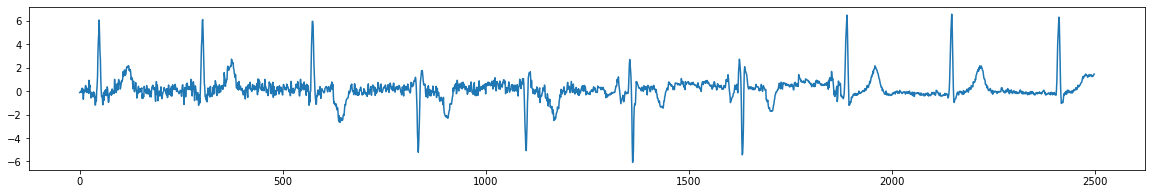

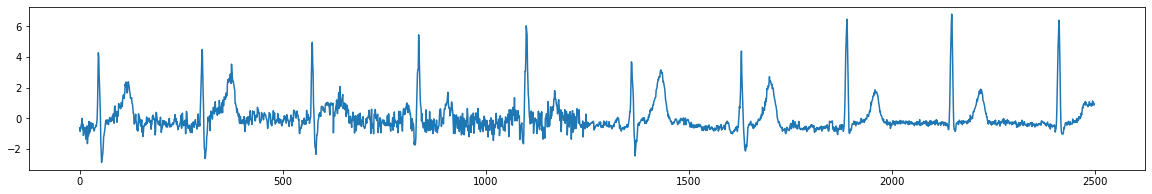

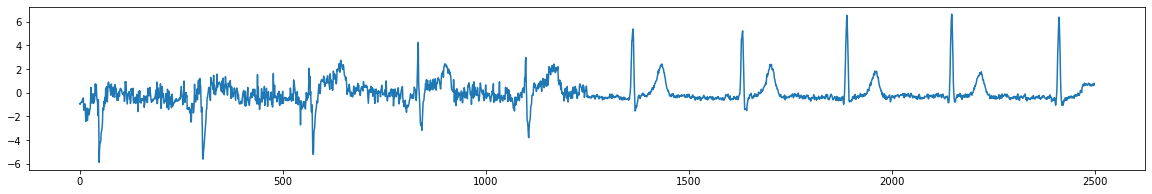

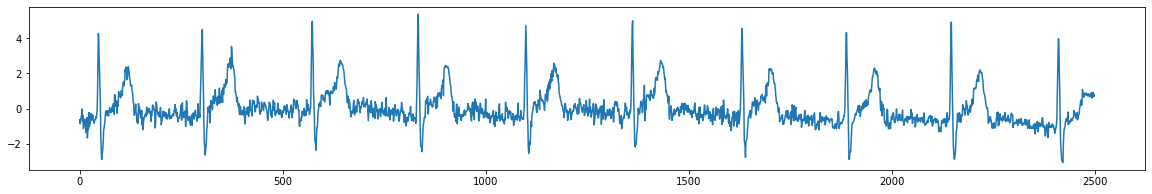

In [40]:
# Visualise the output data from the tf.Dataset

plt.figure(figsize=(20,3))
plt.plot(list(range(len(ecg[0]))), ecg[0])

plt.figure(figsize=(20,3))
plt.plot(list(range(len(ecg[1]))), ecg[1])

plt.figure(figsize=(20,3))
plt.plot(list(range(len(ecg[2]))), ecg[2])

plt.figure(figsize=(20,3))
plt.plot(list(range(len(ecg[3]))), ecg[3])

## CNN Resnet Construction and Training

In [42]:
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization
from tensorflow.keras.layers import ReLU, Add, MaxPool1D, GlobalAvgPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

In [43]:
def Conv_BatchNorm(x, filters, kernel_size, strides):
    x = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_regularizer=l2(0.03))(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return x

In [44]:
def identity_block(orig_x, num_filters):
    x = Conv_BatchNorm(orig_x, filters=num_filters, kernel_size=5, strides=1)
    x = Conv_BatchNorm(x, filters=num_filters, kernel_size=5, strides=1)
    x = Conv1D(filters=4*num_filters, kernel_size=1, strides=1, kernel_regularizer=l2(0.03))(x)  # notice: filters=4*num_filters
    x = BatchNormalization()(x)
 
    x = Add()([x, orig_x])
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return x

In [45]:
def projection_block(tensor, num_filters, strides):
    # left stream
    x = Conv_BatchNorm(tensor, filters=num_filters, kernel_size=5, strides=strides) #[v]
    x = Conv_BatchNorm(x, filters=num_filters, kernel_size=5, strides=1)
    x = Conv1D(filters=4*num_filters, kernel_size=1, strides=1, kernel_regularizer=l2(0.03))(x)  # notice: filters=4*num_filters
    x = BatchNormalization()(x)
 
    # right stream
    proj_x = Conv1D(filters=4*num_filters, kernel_size=1, strides=strides, kernel_regularizer=l2(0.03))(tensor)  # notice: filters=4*num_filters
    proj_x = BatchNormalization()(proj_x)
 
    x = Add()([x, proj_x])
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    return x

In [46]:
def resnet_block(x, filters, reps, strides):
    x = projection_block(x, num_filters=filters, strides=strides)
    for _ in range(reps-1):
        x = identity_block(x, num_filters=filters)
    return x

In [ ]:
Inp = Input(shape=(2500, 4),name="Inp")
 
x = Conv_BatchNorm(Inp, filters=128, kernel_size=11, strides=2)  
x = MaxPool1D(pool_size=5, strides=2, padding='same')(x)
 
x = resnet_block(x, filters=128, reps=2, strides=1)
x = resnet_block(x, filters=256, reps=2, strides=2)
x = resnet_block(x, filters=512, reps=2, strides=2)
x = resnet_block(x, filters=1024, reps=1, strides=2) 
 
x = GlobalAvgPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)
 
model = Model(Inp, output, name='simple-res')

In [48]:
model.summary()

Model: "simple-res"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp (InputLayer)                [(None, 2500, 4)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1250, 128)    5760        Inp[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1250, 128)    512         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1250, 128)    0           batch_normalization[0][0]        
_________________________________________________________________________________________

In [49]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00002)
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.25) # label smoothing to prevent large weights

model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

In [50]:
filepath="mi_checkpoints/weights-{epoch:02d}.hdf5"
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath, verbose=1, save_weights_only=True)

In [ ]:
model.fit(train_dataset,
          steps_per_epoch = int(109343/64),
          epochs=25,
          class_weight={0:1.0, 1:2.0},
          callbacks=[checkpoint_cb]
          )

Epoch 1/25
1708/1708 [==============================] - 4159s 2s/step - loss: 298.1616 - accuracy: 0.4895

Epoch 00001: saving model to mi_checkpoints/weights-01.hdf5
Epoch 2/25
1708/1708 [==============================] - 4077s 2s/step - loss: 24.8653 - accuracy: 0.6990

Epoch 00002: saving model to mi_checkpoints/weights-02.hdf5
Epoch 3/25
1708/1708 [==============================] - 3990s 2s/step - loss: 3.7792 - accuracy: 0.7983

Epoch 00003: saving model to mi_checkpoints/weights-03.hdf5
Epoch 4/25
1708/1708 [==============================] - 3997s 2s/step - loss: 1.4924 - accuracy: 0.8374

Epoch 00004: saving model to mi_checkpoints/weights-04.hdf5
Epoch 5/25
1708/1708 [==============================] - 4006s 2s/step - loss: 1.0992 - accuracy: 0.8503

Epoch 00005: saving model to mi_checkpoints/weights-05.hdf5
Epoch 6/25
1708/1708 [==============================] - 3996s 2s/step - loss: 0.9773 - accuracy: 0.8566

Epoch 00006: saving model to mi_checkpoints/weights-06.hdf5
Epoch 7

In [429]:
# load the best set of weights

model.load_weights("mi_checkpoints/weights-17.hdf5")
model.compile(optimizer=opt, loss=bce, metrics=['accuracy'])

## Results

Precision = Out of all cases that are PREDICTED as positive, how many of them are ACTUALLY positive

Recall = Out of all cases that are ACTUALLY positive, how many of them are PREDICTED as positive

True Positive Rate = if a patient actually has Afl, how many percent of the time will the algorithm identify that he has Afl

False Positive Rate = if a patient actually does NOT have Afl, how many percent of the time will the algorithm say that he has Afl

### Train Results

In [430]:
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix

In [432]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(get_val)
train_dataset = train_dataset.batch(64, drop_remainder=False)

In [ ]:
y_pred = model.predict(train_dataset)

In [435]:
mi_true = y_train.T[0]
mi_pred = y_pred.T[0]

mi_pred = np.around(mi_pred).astype(np.int)

In [ ]:
cf_m = confusion_matrix(mi_true, mi_pred)

True Postive Rate: 0.992789020702489
False Postive Rate: 0.27814484158958325


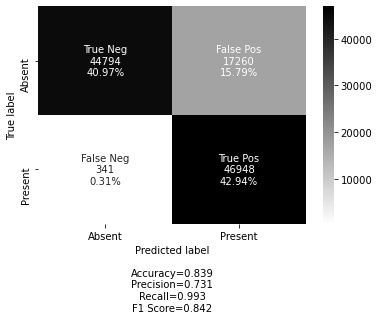

In [438]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

### Val Results

In [439]:
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.map(get_val)
val_dataset = val_dataset.batch(64, drop_remainder=False)

In [440]:
y_pred = model.predict(val_dataset)

In [444]:
mi_true = y_val.T[0]
mi_pred = y_pred.T[0]

mi_pred = np.around(mi_pred).astype(np.int)

In [ ]:
cf_m = confusion_matrix(mi_true, mi_pred)

True Postive Rate: 0.989010989010989
False Postive Rate: 0.28437762147512424


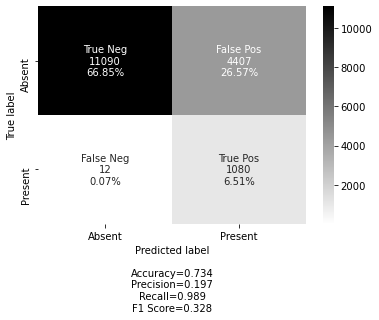

In [446]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Absent', 'Present']
make_confusion_matrix(cf_m,
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

print('True Postive Rate: {}'.format(cf_m[1][1]/(cf_m[1][0] + cf_m[1][1])))
print('False Postive Rate: {}'.format(cf_m[0][1]/(cf_m[0][0] + cf_m[0][1])))

## Save Model

In [447]:
model.save('mi_model.h5')

## Load Model

In [448]:
# To use the model, simply load the model

loaded_model = tf.keras.models.load_model('mi_model_1.h5')
loaded_model.summary()

Model: "simple-res"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inp (InputLayer)                [(None, 2500, 4)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1250, 128)    5760        Inp[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1250, 128)    512         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1250, 128)    0           batch_normalization[0][0]        
_________________________________________________________________________________________

In [ ]:
# Then, use the model wit the following command

loaded_model.predict(X)